# Wavelets

https://en.wikipedia.org/wiki/Wavelet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import signal

## Wavelet time

Let's sort this out once and for all.

- A wavelet length 0.008 s w 0.004 s sampling should be 3 samples long, even though 0.008 / 0.004 = 2. Unless the user specifies `sym=False`. So if `duration/dt` is even, and `sym` is `True`, add a sample. If `sym` is False, do nothing.
- A wavelet length 0.012 s w 0.004 s sampling should be 3 samples long. Unless the user specifies `sym=False`. So, if `duration/dt` is odd, and `sym` is `True`, keep that number of samples. If `sym` is False, add a sample.

In [3]:
import bruges as bg

x = np.array([-1.59650205e-18,   2.75409007e-03,  -3.01670223e-03,
           -3.63692317e-02,  -1.63002095e-02,  -5.20943260e-02,
           -2.83497662e-01,   2.76098252e-01,   9.82157437e-01,
            2.38730442e-01,  -2.10312350e-01,  -3.25806534e-02,
           -8.30581776e-03,  -1.39615614e-02,  -6.55916221e-04,
           -2.28078034e-18])
y = bg.filters.sweep(0.064, 0.004, f=[10, 100])
y


<ipython-input-3-bb04b2d23732>:9: FutureWarning: In future releases, return_t will be True by default.
  y = bg.filters.sweep(0.064, 0.004, f=[10, 100])
/Users/matt/opt/miniconda3/envs/bruges/lib/python3.8/site-packages/bruges/filters/wavelets.py:344: FutureWarning: In future releases, the default legacy behaviour will be removed. We recommend setting sym=True. This will be the default in v0.5+.
  t = get_time(duration, dt, sym=sym)


array([-1.54351918e-18,  2.84406611e-03, -1.72421336e-03, -3.99653471e-02,
       -4.05717648e-02, -6.71907819e-02, -2.90783101e-01,  2.21544774e-01,
        9.82157437e-01,  1.91560364e-01, -2.15717043e-01, -4.20222267e-02,
       -2.06734573e-02, -1.53420521e-02, -3.74892656e-04, -2.35529337e-18])

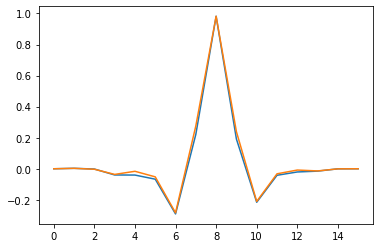

In [4]:
plt.plot(y)
plt.plot(x)

In [5]:
import warnings
import numpy as np

def get_time(duration, dt, sym=None):
    """
    Make a time vector.

    If `sym` is `True`, the time vector will have an odd number of samples,
    and will be symmetric about 0. If it's False, and the number of samples
    is even (e.g. duration = 0.016, dt = 0.004), then 0 will bot be center.
    """
    if sym is None:
        m = "In future releases, the default legacy behaviour will be removed."
        m += "Symmetric time series will be returned by default, i.e. sym=True."
        warnings.warn(m, category=FutureWarning, stacklevel=2)
        return np.arange(-duration/2, duration/2, dt)
    
    # This business is to avoid some of the issues with `np.arange`:
    # (1) unpredictable length and (2) floating point weirdness, like
    # 1.234e-17 instead of 0. Not using `linspace` because figuring out
    # the length and offset gave me even more of a headache than this.
    n = int(duration / dt)
    odd = n % 2
    k = int(10**-np.floor(np.log10(dt)))
    dti = int(k * dt)  # integer dt
        
    if (odd and sym):
        t = np.arange(n)
    if (not odd and sym):
        t = np.arange(n + 1)
    if (odd and not sym): 
        t = np.arange(n)
    if (not odd and not sym):
        t = np.arange(n) - 1
        
    t -= t[-1] // 2
    
    return dti * t / k

get_time(0.016, 0.004, sym=True)

array([-0.008, -0.004,  0.   ,  0.004,  0.008])

In [305]:
np.arange(3) - 1

array([-1,  0,  1])

In [378]:
import bruges as bg

_, t = bg.filters.ormsby(0.025, 0.005, (5, 10, 20, 30), return_t=True)
t

array([-0.0125, -0.0075, -0.0025,  0.0025,  0.0075])

## Baselevel curve


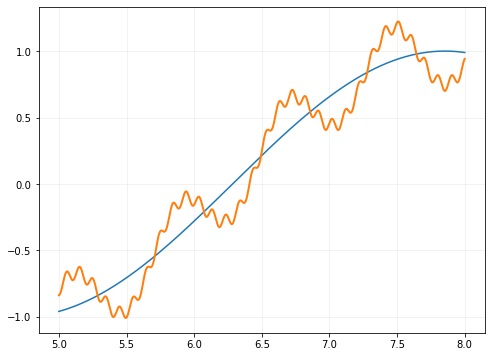

In [22]:
x = np.linspace(5, 8, num=1000)
a = np.sin(x)
c = np.sin(x) - 0.25 * np.cos(8 * x) - 0.05 * np.cos (64 * x)

plt.figure(figsize=(8, 6))
plt.plot(x, a)
plt.plot(x, c, lw=2)
plt.grid('k', alpha=0.2)

## Wavelet func

In [ ]:
# New meta-wavelet function
def wavelet(duration, dt, f, phase=0, kind='ricker', return_t=False, args=None):
    """
    Wraps bruges's wavelet functions, with the added benefit of being able to
    ask for a particular phase, or provide a range of phases.

    Args
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (often one of  0.001, 0.002,
            or 0.004).
        f (array-like): Centre frequency of the wavelet(s) in Hz. If a sequence is
            passed, you will get an extra dimension in return, containing one
            element (row or plane) per frequency.
        phase (array-like): The phase of the wavelet(s). If a sequence is passed,
            you will get an extra dimension in return, containing one element
            (row or plane) per phase value.
        kind (str): the name of the wavelet you want. Must be one of ricker, berlage,
            gabor, cosine, sinc, klauder, sweep, ormsby.
        return_t (bool): If True, then the function returns a tuple of
            wavelet, time-basis, where time is the range from -duration/2 to
            duration/2 in steps of dt.
        args (dict): a dictionary of any special arguments you need to pass
            to the underlying wavelet function.
    """
    wavelets = {'ricker': ricker,
                'berlage': berlage,
                'gabor': gabor,
                'cosine': cosine,
                'sinc': sinc,
                'klauder': klauder,
                'sweep': sweep,
                'ormsby': ormsby,
                # 'butterworth': butterworth,  # Not implemented yet.
                }

    func = wavelets.get(kind.lower())
    if func is None:
        raise NotImplementedError("That wavelet is not implemented yet.")

    if args is None:
        args = {}
    else:
        args['return_t'] = True  # Override whatever user puts.

    w, t = func(duration, dt, f, **args)
    
    w = rotate_phase(w, phase)

    if return_t:
        Wavelet = namedtuple('Wavelet', ['amplitude', 'time'])
        return Wavelet(w, t)
    else:
        return w


## Wavelet timing

See convo in Swung

(64,)


/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/bruges/filters/wavelets.py:205: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


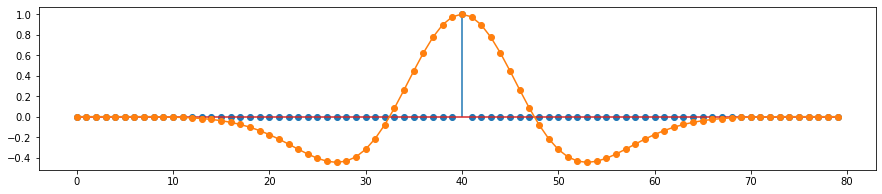

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as bg

w = bg.filters.ricker(0.064, 0.001, 30)
print(w.shape)

arr = np.zeros(80)
arr[40] = 1

plt.figure(figsize=(15, 3))
plt.stem(arr)
plt.plot(np.correlate(arr, w, mode='same'), 'C1o-')


## Butterworth wavelet

Defined by two frequency gradients, then basically just an Ormsby.

Could probably define the Ormsby as a function of the Butterworth.

In [3]:
from scipy import signal

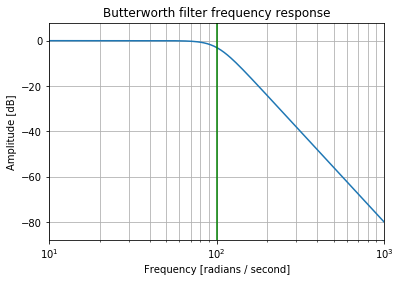

In [7]:
b, a = signal.butter(4, 100, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [16]:
fs = 1000  # Hz
nyq = fs / 2  # Nyquist


b, a = signal.butter(2, (0.1, 0.6), 'low', analog=False)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

ValueError: Must specify a single critical frequency Wn

In [8]:
b

array([1.e+08])

In [9]:
a

array([1.00000000e+00, 2.61312593e+02, 3.41421356e+04, 2.61312593e+06,
       1.00000000e+08])

In [ ]:

def butterworth(duration, dt, f, return_t=False):
    """
    The Butterworth wavelet requires two fequency gradients which together
    define a trapezoid shape in the spectrum. The Ormsby wavelet has several
    sidelobes, unlike Ricker wavelets.

    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (usually 0.001, 0.002,
            or 0.004).
        f (array-like): Sequence of form (f1, f2, f3, f4), or list of lists of
            frequencies, which will return a 2D wavelet bank. Frequencies are
            low-cut, low-pass, high-pass, high-cut.

    Returns:
        ndarray: A vector containing the Ormsby wavelet, or a bank of them.
    """
    f = np.asanyarray(f).reshape(-1, 1)

    try:
        f1, f2, f3, f4 = f
    except ValueError:
        raise ValueError("The last dimension of the frequency array must be 4")

    def numerator(f, t):
        return (np.sinc(f * t)**2) * ((np.pi * f) ** 2)

    pf43 = (np.pi * f4) - (np.pi * f3)
    pf21 = (np.pi * f2) - (np.pi * f1)

    t = np.arange(-duration/2, duration/2, dt)

    w = ((numerator(f4, t)/pf43) - (numerator(f3, t)/pf43) -
         (numerator(f2, t)/pf21) + (numerator(f1, t)/pf21))

    w = np.squeeze(w) / np.amax(w)

    if return_t:
        ButterworthWavelet = namedtuple('ButterworthWavelet', ['amplitude', 'time'])
        return ButterworthWavelet(w, t)
    else:
        return w


## Gabor wavelet

$$ f(x) = e^{-(x - x_0)^2/a^2}e^{-i k_0(x-x_0)} $$

Also used as (maybe bad?) name for 'modified Morlet', which is just a cosine tapered by a Gaussian.

In [8]:
from collections import namedtuple
def gabor(duration, dt, f, return_t=False):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2, duration/2, dt)

    ft = f * t
    w = np.exp(-2 * ft**2) * np.cos(2 * np.pi * ft)
    
#     gauss = scipy.signal.gaussian()
    w = np.squeeze(w)

    if return_t:
        GaborWavelet = namedtuple('GaborWavelet', ['amplitude', 'time'])
        return GaborWavelet(w, t)
    else:
        return w

In [9]:
f = 35
w, t = gabor(0.128, 0.001, f, return_t=True)

In [10]:
from bruges.filters import ricker
wr, _ = ricker(0.128, 0.001, f, return_t=True)

In [11]:
c = np.cos(2 * f * np.pi * t)

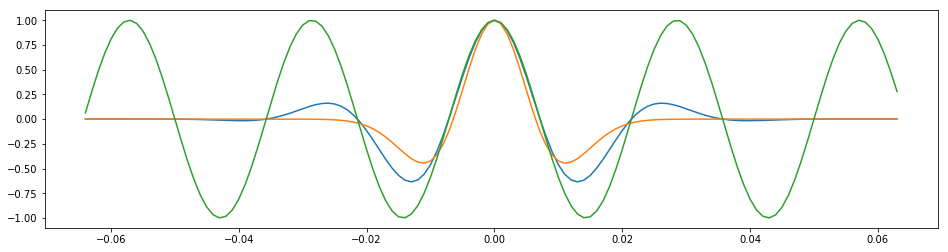

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(t, w)
plt.plot(t, wr)
plt.plot(t, c)

## Sinc and Shannon wavelets

See https://en.wikipedia.org/wiki/Shannon_wavelet

$$ \psi^{(\operatorname{Sha}) }(t) = \operatorname{sinc} \left( \frac {t} {2}\right)\cdot \cos \left( \frac {3 \pi t} {2}\right) $$

or

$$ \psi^{(\operatorname{Sha})}(t)=2 \cdot \operatorname{sinc}(2t - 1)-\operatorname{sinc}(t) $$

where

$$ \operatorname{sinc}(t):= \frac {\sin {\pi t}} {\pi t} $$

First, a pure sinc... I think I made this up.

In [55]:
def generic(func, duration, dt, f, return_t=False, taper='blackman'):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2., duration/2., dt)
    t[t == 0] = 1e-12  # Avoid division by zero.
    f[f == 0] = 1e-12  # Avoid division by zero.
    
    w = np.squeeze(func(t, f))

    if taper:
        tapers = {
            'bartlett': np.bartlett,
            'blackman': np.blackman,
            'hamming': np.hamming,
            'hanning': np.hanning,
            'none': lambda _: 1,
        }
        taper = tapers.get(taper, taper)
        w *= taper(t.size)

    if return_t:
        Wavelet = namedtuple('Wavelet', ['amplitude', 'time'])
        return Wavelet(w, t)
    else:
        return w
    
def sinc(duration, dt, f, return_t=False, taper='blackman'):
    """
    Plain sinc function, tapered.
    """
    func = lambda t_, f_: np.squeeze(np.sin(2*np.pi*f_*t_) / (2*np.pi*f_*t_))
    return generic(func, duration, dt, f, return_t, taper)

import scipy.signal

def cosine(duration, dt, f, return_t=False, taper='gaussian', sigma=None):
    """
    With the default Gaussian window, equivalent to a 'modified Morlet'
    or 'Gabor' wavelet.
    
    Args:
        sigma (float): Width of the default Gaussian window, in seconds.
            Defaults to 1/8 of the duration.
    """
    if sigma is None:
        sigma = duration / 8
    func = lambda t_, f_: np.cos(2 * np.pi * f_ * t_)
    taper = lambda length: scipy.signal.gaussian(length, sigma/dt)
    return generic(func, duration, dt, f, return_t, taper)

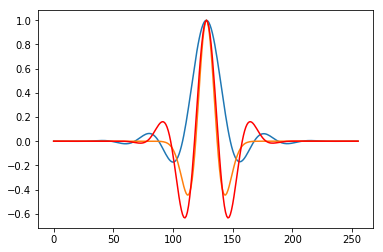

In [73]:
def kaiser(length):
    return np.kaiser(length, beta=10)

plt.plot(sinc(0.256, 0.001, 25, taper=kaiser))
plt.plot(ricker(0.256, 0.001, 25))
plt.plot(gabor(0.256, 0.001, 25), 'r')

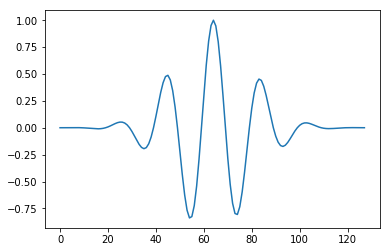

In [66]:
def kaiser(length):
    return np.kaiser(length, beta=10)

plt.plot(cosine(0.128, 0.001, 50, sigma=0.016))

In [65]:
0.128/8

0.016

### Shannon using sincs

In [107]:
def sinc2(duration, dt, f):
    t = np.arange(-duration/2., duration/2., dt)
    return t, np.sinc(0.5*np.pi*f*t)

In [108]:
def shannon2(duration, dt, f):
    t = np.arange(-duration/2., duration/2., dt)
    return t, 2 * np.sinc(2*np.pi*f*t - 1) - np.sinc(2*np.pi*f*t)

In [109]:
sinc(0.512, 0.001, 50, return_t=True)[1].shape

(512,)

In [110]:
sinc2(0.512, 0.001, 50)[0].shape

(512,)

In [111]:
shannon2(0.512, 0.001, 50)[1].shape

(512,)

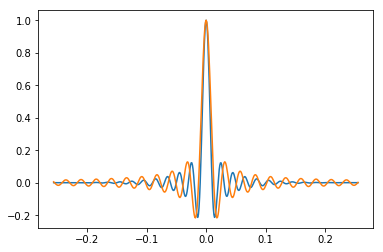

In [112]:
s, t = sinc(0.512, 0.001, 50, return_t=True)

plt.plot(t, s)
plt.plot(*sinc2(0.512, 0.001, 50))
#plt.plot(*shannon2(0.512, 0.001, 50))

In [94]:
def shannon(duration, dt, f):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2., duration/2., dt)
    t[t == 0] = 1e-12  # Avoid division by zero.
    f[f == 0] = 1e-12  # Avoid division by zero.
    return t, np.squeeze(np.sinc(2*np.pi*f*t) * np.cos(3 * np.pi * f * t))

In [223]:
t.shape

(128,)

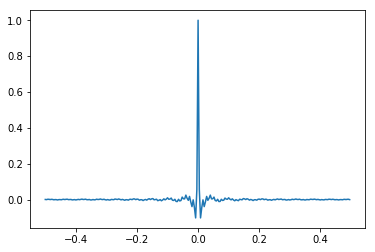

In [224]:
plt.plot(*shannon(1, 0.004, 50))